# October 10th, 2021

**Motivation**: Initial exploration of ROIs projected in 2D optical space <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import Allen
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
mice = Mice(Config(256, 4, 100), load_preproc=True, load_allen=True, load_parcel=True)

In [3]:
from register.register import *
reg = Register(mice)

In [4]:
reg.in_house

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (160, 90, 118)
         Spacing    : (100.0, 100.0, 100.0)
         Origin     : (-7.8, -6.2, 6.4)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

<matplotlib.image.AxesImage object at 0x7e4fc5f1c4f0>

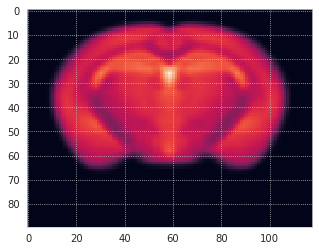

In [5]:
plt.imshow(reg.in_house[78])

<matplotlib.image.AxesImage object at 0x7e51eb059610>

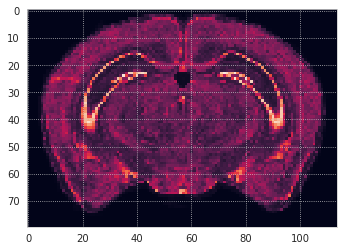

In [6]:
plt.imshow(reg.nissl[78])

## Compare performance

In [7]:
dlist = []
for sub in mice.cfg.sub_ids:
    for ses in mice.cfg.ses_ids:
        key = mice.get_key(sub, ses)
        
        # ME
        hemis = ants.image_read(pjoin(mice.cfg.masks_dir, f"{key}_space-indiv3d_hemis.nii.gz"))
        iso = ants.image_read(pjoin(mice.cfg.masks_dir, f"{key}_space-indiv3d_iso.nii.gz"))
        misc = ants.image_read(pjoin(mice.cfg.masks_dir, f"{key}_space-indiv3d_misc.nii.gz"))
        m_l = hemis.numpy() == 1
        m_r = hemis.numpy() == 2
        num_l = m_l.sum()
        num_r = m_r.sum()
        
        scores = {
            'num_l': num_l,
            'num_r': num_r,
            'delta_lr_min': abs(num_l - num_r) / min(num_l, num_r),
            'delta_lr_max': abs(num_l - num_r) / max(num_l, num_r),
        }

        misc_np = misc.numpy()
        misc_ids = np.unique(misc_np[misc_np.nonzero()])
        misc_ids = [int(e) for e in misc_ids]
        misc_df = reg.mice.al.get(misc_ids)
        sym_dict = dict(zip(misc_df['acronym'], misc_df['id']))
        sym_dict = {
            k: misc_np == i
            for k, i in sym_dict.items()
        }
        sym_dict['iso'] = iso.numpy().astype(bool)

        for _k, x in sym_dict.items():
            scores[f"sym_{_k}"] = symmetry_score(x, m_l, m_r)
        scores = {
            k: 0.0 if np.isnan(s) else s
            for k, s in scores.items()
        }

        _ = sym_dict.pop('iso')

        vox = reg.mice.al.get_masks(list(sym_dict), False)
        vox = {k: v.astype(bool).sum() for k, v in vox.items()}
        sym, ovp = 0, 0
        for _k, size in vox.items():
            sym += size * scores[f"sym_{_k}"]
        scores.update({
            'sym': sym / sum(vox.values()),
        })

        dlist.append({
            'key': [key] * len(scores),
            'tag': ['me'] * len(scores),
            'label': scores.keys(),
            'value': scores.values(),
        })
        
        
        # BIS
        try:
            hemis_bis = ants.image_read(pjoin(mice.cfg.masks_dir, f"{key}_space-indiv3d-BIS_hemis.nii.gz"))
            iso_bis = ants.image_read(pjoin(mice.cfg.masks_dir, f"{key}_space-indiv3d-BIS_iso.nii.gz"))
            misc_bis = ants.image_read(pjoin(mice.cfg.masks_dir, f"{key}_space-indiv3d-BIS_misc.nii.gz"))
        except ValueError:
            print(f"key: {key}, BIS not found")
        
        m_l = hemis_bis.numpy() == 1
        m_r = hemis_bis.numpy() == 2
        num_l = m_l.sum()
        num_r = m_r.sum()
        
        scores = {
            'num_l': num_l,
            'num_r': num_r,
            'delta_lr_min': abs(num_l - num_r) / min(num_l, num_r),
            'delta_lr_max': abs(num_l - num_r) / max(num_l, num_r),
        }

        misc_np = misc_bis.numpy()
        misc_ids = np.unique(misc_np[misc_np.nonzero()])
        misc_ids = [int(e) for e in misc_ids]
        misc_df = reg.mice.al.get(misc_ids)
        sym_dict = dict(zip(misc_df['acronym'], misc_df['id']))
        sym_dict = {
            k: misc_np == i
            for k, i in sym_dict.items()
        }
        sym_dict['iso'] = iso_bis.numpy().astype(bool)

        for _k, x in sym_dict.items():
            scores[f"sym_{_k}"] = symmetry_score(x, m_l, m_r)
        scores = {
            k: 0.0 if np.isnan(s) else s
            for k, s in scores.items()
        }

        _ = sym_dict.pop('iso')

        vox = reg.mice.al.get_masks(list(sym_dict), False)
        vox = {k: v.astype(bool).sum() for k, v in vox.items()}
        sym, ovp = 0, 0
        for _k, size in vox.items():
            sym += size * scores[f"sym_{_k}"]
        scores.update({
            'sym': sym / sum(vox.values()),
        })
        
        dlist.append({
            'key': [key] * len(scores),
            'tag': ['bis'] * len(scores),
            'label': scores.keys(),
            'value': scores.values(),
        })
        
df = pd.DataFrame(merge_dicts(dlist))

key: sub-SLC05_ses-2, BIS not found

In [8]:
_df = df.loc[df['key'] != 'sub-SLC05_ses-2']

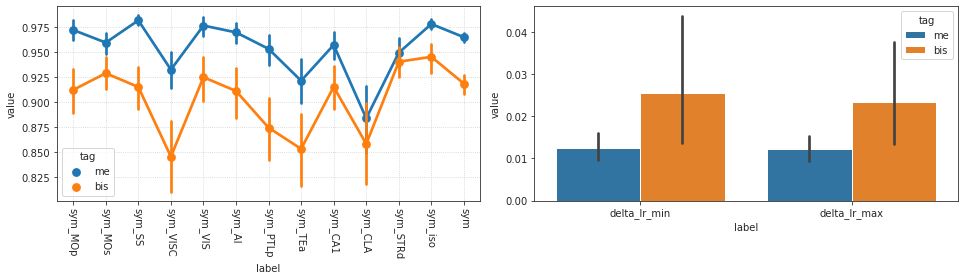

In [10]:
fig, axes = create_figure(1, 2, (13.5, 4))

selec_df = _df.loc[~_df['label'].isin(['num_l', 'num_r', 'delta_lr_min', 'delta_lr_max'])]
sns.pointplot(data=selec_df, x='label', y='value', hue='tag', ax=axes[0])
axes[0].tick_params(axis='x', rotation=-90)
axes[0].grid()

selec_df = _df.loc[_df['label'].isin(['delta_lr_min', 'delta_lr_max'])]
sns.barplot(data=selec_df, x='label', y='value', hue='tag', ax=axes[1])
axes[1].tick_params(axis='x', rotation=0)
plt.show()

## Load one individual Ca

In [36]:
key = 'sub-SLC08_ses-2'

mask = mice.mask2d[key].load_ants('unsigned int')

roi_2d = ants.image_read(
    filename=pjoin(mice.cfg.masks_dir, f"{key}_space-indiv2d_cortex-merged.nii.gz"),
    pixeltype='unsigned int',
)
roi_2d = reset_ants_img(roi_2d.numpy().squeeze(), spacing=roi_2d.spacing[:2], origin=0, use_um=False)

ref = mice.ref[key].load_ants('float')
ref = reset_ants_img(ref.numpy().squeeze(), spacing=ref.spacing[:2], origin=0, use_um=False)

roi_2d = ants.resample_image_to_target(roi_2d, mask, interp_type='genericLabel')
ref = ants.resample_image_to_target(ref, mask, interp_type='linear')

roi_2d *= mask
ref *= mask

<matplotlib.image.AxesImage object at 0x7edcc5ef9400>

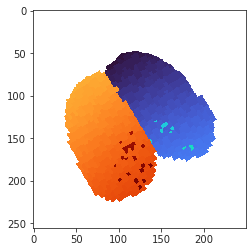

In [37]:
roi_2d_np = roi_2d.numpy().astype(int).squeeze()
regions2d = np.unique(roi_2d_np[roi_2d_np.nonzero()])

roi_2d_np = roi_2d_np.astype(float)
roi_2d_np[roi_2d_np == 0] = np.nan

plt.imshow(roi_2d_np, cmap='turbo')

In [38]:
len(regions2d)

329

In [39]:
hcl = mice.parcel.decode(regions2d)[0]

In [25]:
hcl[:, -1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [59]:
hcl[hcl[:, -1] == 1]

array([[  1, 176,   1],
       [  1, 182,   1],
       [  1, 192,   1],
       [  1, 199,   1],
       [  1, 201,   1],
       [  1, 235,   1],
       [  1, 238,   1],
       [  2, 158,   1],
       [  2, 166,   1],
       [  2, 176,   1],
       [  2, 182,   1],
       [  2, 185,   1],
       [  2, 190,   1],
       [  2, 192,   1],
       [  2, 195,   1],
       [  2, 197,   1],
       [  2, 199,   1],
       [  2, 218,   1],
       [  2, 221,   1],
       [  2, 224,   1],
       [  2, 229,   1],
       [  2, 230,   1],
       [  2, 235,   1],
       [  2, 241,   1],
       [  2, 244,   1]])

In [60]:
hcl[hcl[:, -1] == 0]

array([[  1,  16,   0],
       [  1,  20,   0],
       [  1,  22,   0],
       [  1,  23,   0],
       [  1,  24,   0],
       [  1,  25,   0],
       [  1,  27,   0],
       [  1,  29,   0],
       [  1,  31,   0],
       [  1,  33,   0],
       [  1,  34,   0],
       [  1,  35,   0],
       [  1,  37,   0],
       [  1,  39,   0],
       [  1,  41,   0],
       [  1,  42,   0],
       [  1,  44,   0],
       [  1,  45,   0],
       [  1,  48,   0],
       [  1,  49,   0],
       [  1,  50,   0],
       [  1,  53,   0],
       [  1,  54,   0],
       [  1,  55,   0],
       [  1,  57,   0],
       [  1,  58,   0],
       [  1,  59,   0],
       [  1,  62,   0],
       [  1,  67,   0],
       [  1,  68,   0],
       [  1,  69,   0],
       [  1,  70,   0],
       [  1,  71,   0],
       [  1,  72,   0],
       [  1,  73,   0],
       [  1,  74,   0],
       [  1,  76,   0],
       [  1,  80,   0],
       [  1,  83,   0],
       [  1,  85,   0],
       [  1,  86,   0],
       [  1,  87,   0],
       [  1,  88,   0],
       [  1,  89,   0],
       [  1,  90,   0],
       [  1,  93,   0],
       [  1,  97,   0],
       [  1,  98,   0],
       [  1, 100,   0],
       [  1, 101,   0],
       [  1, 102,   0],
       [  1, 103,   0],
       [  1, 104,   0],
       [  1, 105,   0],
       [  1, 107,   0],
       [  1, 108,   0],
       [  1, 109,   0],
       [  1, 110,   0],
       [  1, 112,   0],
       [  1, 114,   0],
       [  1, 118,   0],
       [  1, 119,   0],
       [  1, 120,   0],
       [  1, 121,   0],
       [  1, 123,   0],
       [  1, 125,   0],
       [  1, 126,   0],
       [  1, 127,   0],
       [  1, 131,   0],
       [  1, 132,   0],
       [  1, 134,   0],
       [  1, 136,   0],
       [  1, 137,   0],
       [  1, 138,   0],
       [  1, 139,   0],
       [  1, 141,   0],
       [  1, 143,   0],
       [  1, 146,   0],
       [  1, 147,   0],
       [  1, 148,   0],
       [  1, 150,   0],
       [  1, 152,   0],
       [  1, 155,   0],
       [  1, 156,   0],
       [  1, 157,   0],
       [  1, 158,   0],
       [  1, 159,   0],
       [  1, 160,   0],
       [  1, 161,   0],
       [  1, 164,   0],
       [  1, 166,   0],
       [  1, 167,   0],
       [  1, 170,   0],
       [  1, 171,   0],
       [  1, 173,   0],
       [  1, 174,   0],
       [  1, 175,   0],
       [  1, 176,   0],
       [  1, 177,   0],
       [  1, 180,   0],
       [  1, 181,   0],
       [  1, 182,   0],
       [  1, 183,   0],
       [  1, 184,   0],
       [  1, 185,   0],
       [  1, 187,   0],
       [  1, 189,   0],
       [  1, 190,   0],
       [  1, 191,   0],
       [  1, 192,   0],
       [  1, 195,   0],
       [  1, 196,   0],
       [  1, 197,   0],
       [  1, 198,   0],
       [  1, 199,   0],
       [  1, 201,   0],
       [  1, 202,   0],
       [  1, 203,   0],
       [  1, 205,   0],
       [  1, 207,   0],
       [  1, 208,   0],
       [  1, 209,   0],
       [  1, 210,   0],
       [  1, 211,   0],
       [  1, 213,   0],
       [  1, 214,   0],
       [  1, 215,   0],
       [  1, 218,   0],
       [  1, 219,   0],
       [  1, 220,   0],
       [  1, 221,   0],
       [  1, 223,   0],
       [  1, 224,   0],
       [  1, 225,   0],
       [  1, 227,   0],
       [  1, 228,   0],
       [  1, 229,   0],
       [  1, 230,   0],
       [  1, 232,   0],
       [  1, 233,   0],
       [  1, 234,   0],
       [  1, 235,   0],
       [  1, 236,   0],
       [  1, 237,   0],
       [  1, 238,   0],
       [  1, 240,   0],
       [  1, 241,   0],
       [  1, 242,   0],
       [  1, 243,   0],
       [  1, 244,   0],
       [  1, 245,   0],
       [  1, 247,   0],
       [  1, 249,   0],
       [  2,  16,   0],
       [  2,  20,   0],
       [  2,  23,   0],
       [  2,  24,   0],
       [  2,  25,   0],
       [  2,  27,   0],
       [  2,  29,   0],
       [  2,  31,   0],
       [  2,  32,   0],
       [  2,  33,   0],
       [  2,  34,   0],
       [  2,  35,   0],
       [  2,  37,   0],
       [  2,  39

In [61]:
i = mice.parcel.encode(2, 244, 0)
j = mice.parcel.encode(2, 244, 1)
i, j

(1268, 1524)

In [62]:
i in regions2d, j in regions2d

(True, True)

In [40]:
x = roi_2d.numpy().copy()

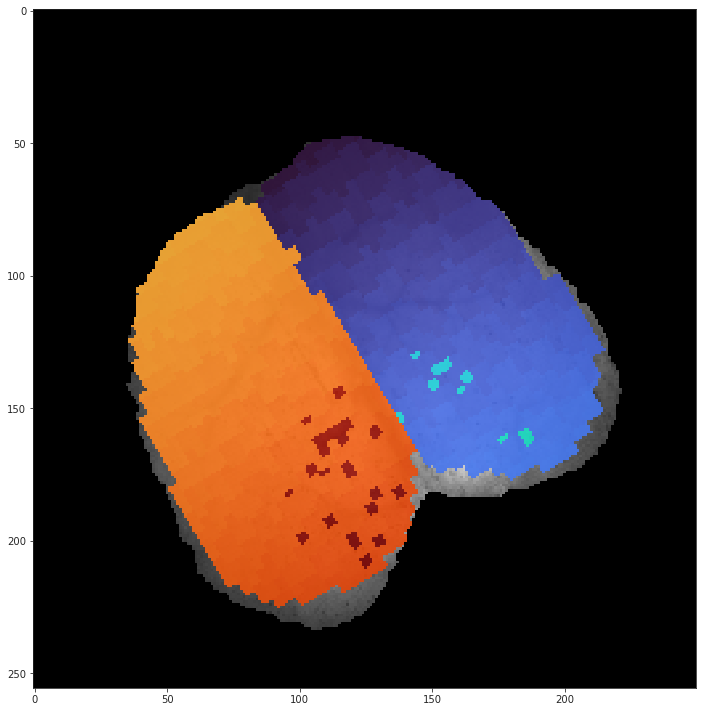

In [41]:
fig, ax = create_figure(1, 1, (12, 10))
ax.imshow(ref.numpy(), cmap='Greys_r')
ax.imshow(np.ma.masked_where(~x.astype(bool), x), alpha=0.9, cmap='turbo')
plt.show()

In [42]:
x = roi_2d.numpy().copy()

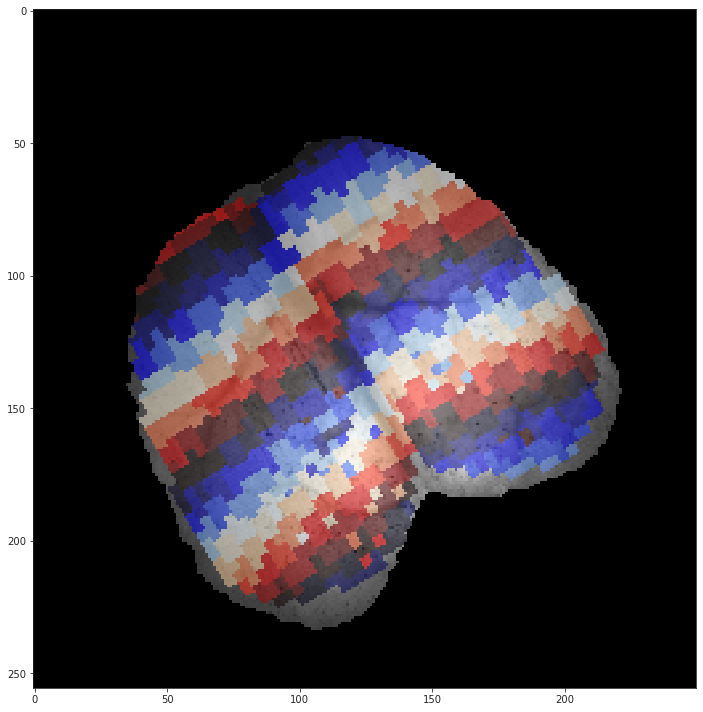

In [43]:
fig, ax = create_figure(1, 1, (12, 10))
ax.imshow(ref.numpy(), cmap='Greys_r')
ax.imshow(np.ma.masked_where(~x.astype(bool), x), alpha=0.5, cmap='flag_r')
plt.show()

In [9]:
key = 'sub-SLC10_ses-3'

In [10]:
indiv = mice.T1w[key].load_ants()
indiv

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [11]:
mask = mice.mask3d[key].load_ants()
mask

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [12]:
mice.mask3d[key].nii_file

'sub-SLC10_ses-3_space-individual_desc-mask_bold.nii.gz'

<matplotlib.image.AxesImage object at 0x7fa5d52b1eb0>

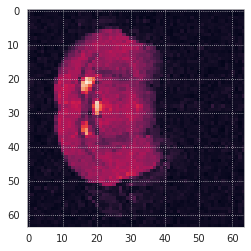

In [13]:
plt.imshow(indiv[..., 40])

In [14]:
indiv *= mask

<matplotlib.image.AxesImage object at 0x7fa5d50b9b20>

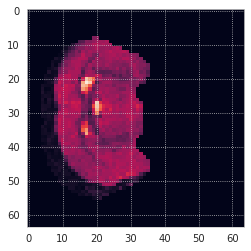

In [15]:
plt.imshow(indiv[..., 40])

In [19]:
indiv_prep

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (78, 64, 64)
         Spacing    : (200.0, 200.0, 200.0)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [16]:
indiv_prep = reg._prepare(indiv)

<matplotlib.image.AxesImage object at 0x7fa5d49640d0>

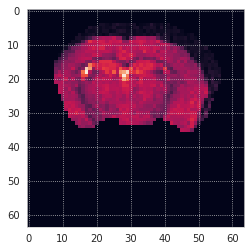

In [18]:
plt.imshow(indiv_prep[40])

In [216]:
indiv

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [217]:
np.array(indiv)

array(ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
, dtype=object)

In [221]:
indiv.origin

(6.400000095367432, -6.200000286102295, -7.800000190734863)

In [222]:
indiv.spacing

(0.20000000298023224, 0.20000000298023224, 0.20000000298023224)

In [223]:
indiv.dtype

'float32'

In [225]:
reg.in_house_name

'Symmetric_N162'

In [226]:
resolution = 100
spacing_mm = resolution / 1000
file = [
    f"{reg.in_house_name}",
    f"{spacing_mm:.2f}.nii.gz",
]
file = '_'.join(file)
file = pjoin(
    reg.mice.cfg.base_dir, 'Yale',
    'atlases_templates', file,
)
img = ants.image_read(file)

In [227]:
img

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (118, 90, 160)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [20]:
org = (6.4, -6.2, -7.8)

In [21]:
reg.tr_axes

(2, 1, 0)

In [22]:
tuple(org[i] for i in reg.tr_axes)

(-7.8, -6.2, 6.4)

In [220]:
indiv.direction

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

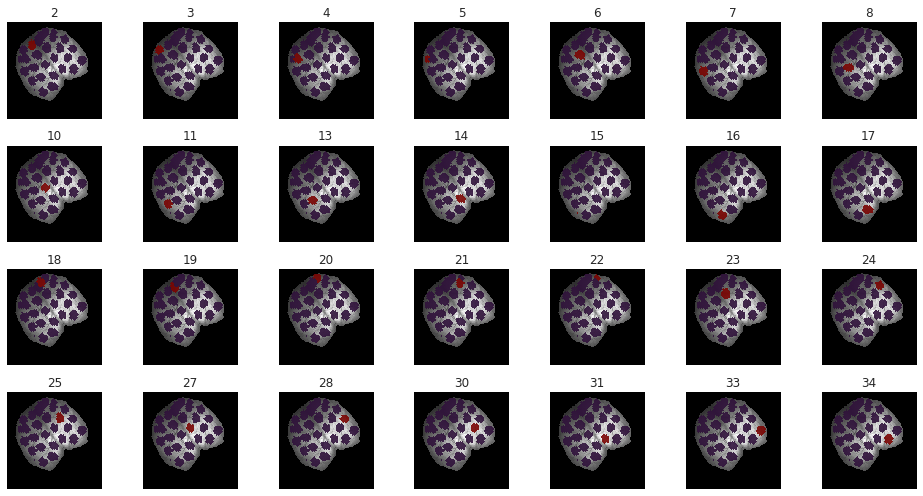

In [189]:
fig, axes = create_figure(4, 7, (13.5, 7))

for i, ax in zip(np.unique(x[x > 0]), axes.ravel()):
    ax.imshow(ref, cmap='Greys_r')
    ax.imshow(np.ma.masked_where(~x.astype(bool), x == i), alpha=0.9, cmap='turbo')
    ax.set_title(i)
remove_ticks(axes)
plt.show()

In [190]:
counts = {}
for i in np.unique(x[x > 0]):
    counts[i] = (x == i).sum()

<AxesSubplot:ylabel='Count'>

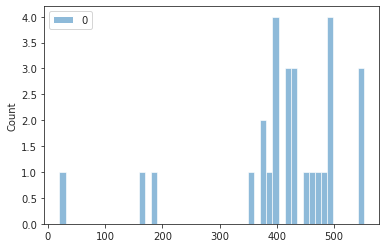

In [193]:
sns.histplot(counts.values(), bins=50)

In [197]:
np.mean(list(counts.values())), np.std(list(counts.values()))

(411.07142857142856, 115.1725192208344)

In [198]:
np.mean(list(counts.values())) - 3 * np.std(list(counts.values()))

65.55387090892532

In [181]:
mice = Mice(Config(17, resolution=25), load_preproc=True)

<matplotlib.image.AxesImage object at 0x7e295c085e20>

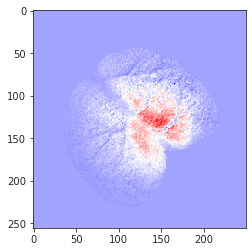

In [183]:
ca = mice.ca_preproc['sub-SLC01_ses-1_run-1'].get_data()
plt.imshow(ca[..., 10], cmap='bwr')

In [184]:
ca.shape

(256, 250, 6000)